In [ ]:
# Last amended: 24th September, 2021
# My folder: lubuntu_spark: /home/ashok/Documents/spark/2.ml/1.demo
# Data Source: http://insideairbnb.com/get-the-data.html
# Ref:
# https://www.linkedin.com/pulse/building-scalable-machine-learning-pipelines-apache-spark-rajat-gupta

## Call libraries

In [1]:
# 1.0 
import numpy as np
import pandas as pd

In [2]:
# 1.1 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# 1.2 Transfer files to hadoop:

! hdfs dfs -rm -r -f /user/ashok/data_files/boston
! hdfs dfs -mkdir -p /user/ashok/data_files/boston
! hdfs dfs -put /cdata/misc_datasets/boston_housing/boston_housing.csv.gz  /user/ashok/data_files/boston
! hdfs dfs -ls /user/ashok/data_files/boston



Found 1 items
-rw-r--r--   1 ashok supergroup      11832 2022-09-16 13:11 /user/ashok/data_files/boston/boston_housing.csv.gz


In [4]:
# 1.3 Display multiple command outputs from a cell  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Read data

In [5]:
# 2.0 Read Data
#     We are only specifying the folder. Not the filename.

df = spark.read.csv(
                    path = "hdfs://localhost:9000/user/ashok/data_files/boston",
                    inferSchema = True,
                    header = True
                   )


In [10]:
# 2.1 A bit about data:

df.columns
len(df.columns)
df.count()

['crimerate',
 'zone',
 'non_retailbusiness',
 'river',
 'pollution',
 'avgrooms',
 'age',
 'wt_distances',
 'highwayaccess',
 'taxrate',
 'pupil_teacherratio',
 'caste_composition',
 'lowerstatus_pop',
 'median_value']

14

506

In [7]:
# 2.2 

df.select(df.columns[:10]).show(3)
df.select(df.columns[10:]).show(3)

+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|crimerate|zone|non_retailbusiness|river|pollution|avgrooms| age|wt_distances|highwayaccess|taxrate|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|  0.00632|18.0|              2.31|    0|    0.538|   6.575|65.2|        4.09|            1|    296|
|  0.02731| 0.0|              7.07|    0|    0.469|   6.421|78.9|      4.9671|            2|    242|
|  0.02729| 0.0|              7.07|    0|    0.469|   7.185|61.1|      4.9671|            2|    242|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
only showing top 3 rows

+------------------+-----------------+---------------+------------+
|pupil_teacherratio|caste_composition|lowerstatus_pop|median_value|
+------------------+-----------------+---------------+------------+
|              15.3|            396.9|           4.98|        24

## Machine Learning

### Rename target
In ml algorthms, default name for target column is 'label'

In [11]:
# 2.3

df = df.withColumnRenamed('median_value', 'label')


### Partition

In [12]:
# 3.0
# 80:20 split

train, test = df.randomSplit([0.8,0.2])

In [13]:
# 3.1

train.count()
test.count()

405

101

### VectorAssembler:

```
  f1       f2       f3          features           label
 1.0      4.1       6.8         [1.0,4.1,6.8]        0
 2.1      8.2       5.5         [2.1,8.2,5.5]        1
 6.5      0.8       0.11        [6.5,0.8,0.11]       1
 3.3      1.9       1.1         [3.3,1.9,1.1]        0
 

```

In [15]:
# 3.2 Assemble all predictors under one column
#     Instantiate VectorAssembler Class

vc = VectorAssembler(
                      inputCols = ['crimerate', 'avgrooms'],
                      outputCol = 'features'
                    )


In [16]:
# 3.3 Transform our data:

tr = vc.transform(train)
te = vc.transform(test)

In [17]:
# 3.4 Check

tr.select(tr.columns[:10]).show(3)
tr.select(tr.columns[10:]).show(3)

+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|crimerate|zone|non_retailbusiness|river|pollution|avgrooms| age|wt_distances|highwayaccess|taxrate|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|  0.00906|90.0|              2.97|    0|      0.4|   7.088|20.8|      7.3073|            1|    285|
|  0.01301|35.0|              1.52|    0|    0.442|   7.241|49.3|      7.0379|            1|    284|
|  0.01311|90.0|              1.22|    0|    0.403|   7.249|21.9|      8.6966|            5|    226|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
only showing top 3 rows

+------------------+-----------------+---------------+-----+---------------+
|pupil_teacherratio|caste_composition|lowerstatus_pop|label|       features|
+------------------+-----------------+---------------+-----+---------------+
|              15.3|           394.72

### Random Forest Regression
Here is its syntax

```
RandomForestRegressor(
                       featuresCol='features',
                       labelCol='label',
                       predictionCol='prediction',
                       maxDepth=5,
                       maxBins=32,
                       minInstancesPerNode=1,
                       minInfoGain=0.0,
                       maxMemoryInMB=256,
                       cacheNodeIds=False, 
                       checkpointInterval=10,
                       impurity='variance',
                       subsamplingRate=1.0,
                       seed=None,
                       numTrees=20,
                       featureSubsetStrategy='auto',
                       leafCol='',
                       minWeightFractionPerNode=0.0,
                       weightCol=None,
                       bootstrap=True
                       )
```

In [15]:
# 4.1 Instantiate RF model:

rf = RandomForestRegressor()

In [16]:
# 4.1 Fit model:

model = rf.fit(tr)

### Prediction

In [17]:
# 5.0
# Make predictions:

te.select(te.columns[:10]).show(3)
te.select(te.columns[10:]).show(3)

+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|crimerate|zone|non_retailbusiness|river|pollution|avgrooms| age|wt_distances|highwayaccess|taxrate|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|  0.00906|90.0|              2.97|    0|      0.4|   7.088|20.8|      7.3073|            1|    285|
|   0.0136|75.0|               4.0|    0|     0.41|   5.888|47.6|      7.3197|            3|    469|
|  0.01381|80.0|              0.46|    0|    0.422|   7.875|32.0|      5.6484|            4|    255|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
only showing top 3 rows

+------------------+-----------------+---------------+-----+---------------+
|pupil_teacherratio|caste_composition|lowerstatus_pop|label|       features|
+------------------+-----------------+---------------+-----+---------------+
|              15.3|           394.72

In [18]:
# 5.1 USe model to make predictions:

out = model.transform(te)

In [19]:
# 5.2

out.columns

['crimerate',
 'zone',
 'non_retailbusiness',
 'river',
 'pollution',
 'avgrooms',
 'age',
 'wt_distances',
 'highwayaccess',
 'taxrate',
 'pupil_teacherratio',
 'caste_composition',
 'lowerstatus_pop',
 'label',
 'features',
 'prediction']

In [20]:
# 5.3

out.select(out.columns[:10]).show(3)
out.select(out.columns[10:]).show(3)

+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|crimerate|zone|non_retailbusiness|river|pollution|avgrooms| age|wt_distances|highwayaccess|taxrate|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|  0.00906|90.0|              2.97|    0|      0.4|   7.088|20.8|      7.3073|            1|    285|
|   0.0136|75.0|               4.0|    0|     0.41|   5.888|47.6|      7.3197|            3|    469|
|  0.01381|80.0|              0.46|    0|    0.422|   7.875|32.0|      5.6484|            4|    255|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
only showing top 3 rows

+------------------+-----------------+---------------+-----+---------------+------------------+
|pupil_teacherratio|caste_composition|lowerstatus_pop|label|       features|        prediction|
+------------------+-----------------+---------------+-----+---------------+

### RMSE

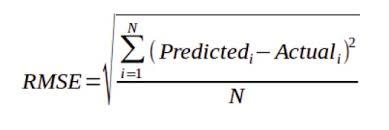

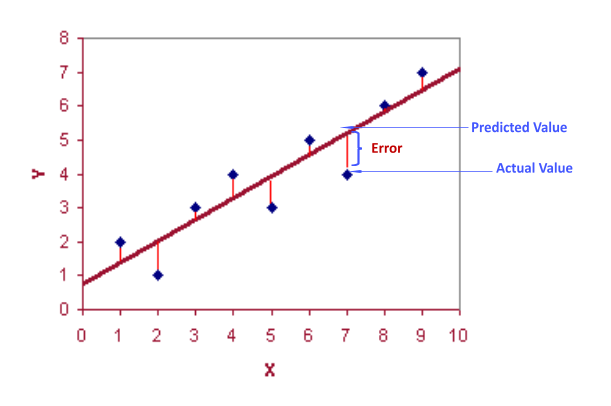

In [21]:
# 5.4 Evaluate performance:

evaluator = RegressionEvaluator(metricName = "rmse")   #   Try 'r2'
evaluator.evaluate(out)

6.0536938579481365

### R-squared
 R-squared Goodness-of-Fit measure <br>
 Can you predict better than a vegetable seller who makes predictions based on past mean sales? 

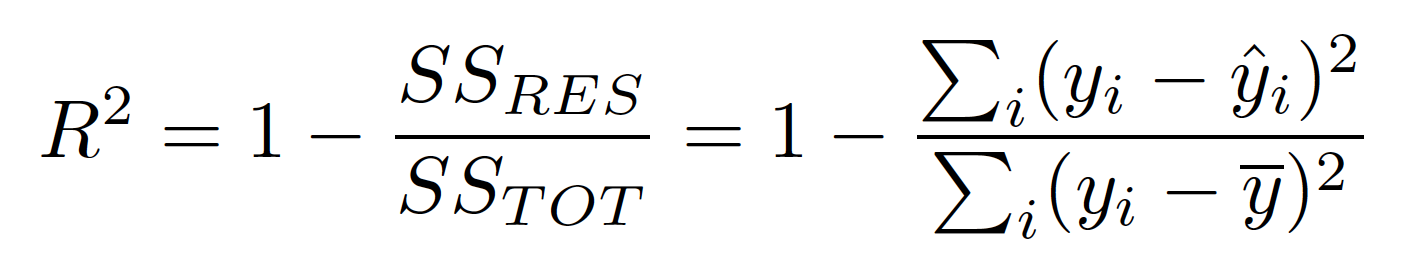

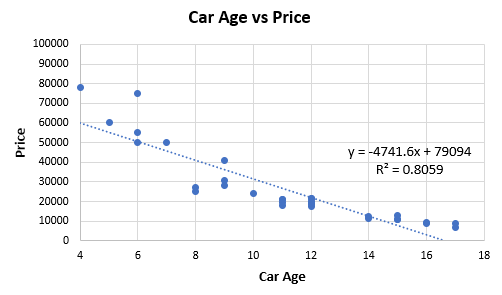

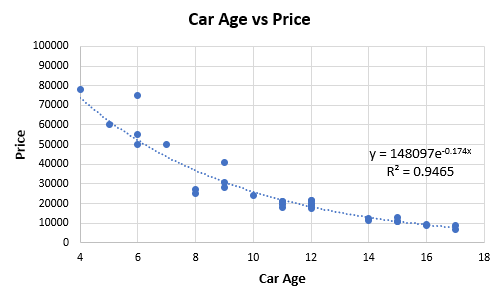

Bettering predictions based on mean

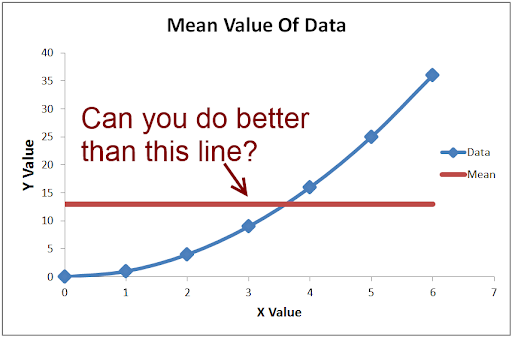

In [ ]:
############# I am done ######################